In [51]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def forward(loga, logb, T, logpi, observations):
    logalpha = np.empty((T, 2))
    logalpha[0, 0] = logpi[0] + logb[0, observations[0]]
    logalpha[0, 1] = logpi[1] + logb[1, observations[0]]
    for t in range(1, T):
        for j in range(2):
            logterms = [loga[i, j] + logalpha[t - 1, i] for i in range(2)]
            logalpha[t, j] = np.logaddexp.reduce(logterms) + logb[j, observations[t]]
        
    return logalpha

def backward(loga, logb, T, observations):
    logbeta = np.empty((T, 2))
    logbeta[T-1, :] = 0
    for t in range(T - 2, -1, -1):
        for i in range(2):
            logterms = [loga[i, j] + logb[j, observations[t+1]] + logbeta[t+1, j] for j in range(2)]
            logbeta[t, i] = np.logaddexp.reduce(logterms)
            
    return logbeta

def compute_gamma(logalpha, logbeta, T):
    loggamma = np.empty((T, 2))
    for t in range(T):
        for i in range(2):
            loggamma[t, i] = logalpha[t, i] + logbeta[t, i] - np.logaddexp.reduce([
                logalpha[t, j] + logbeta[t, j] for j in range(2)
            ])

    return loggamma

def compute_xi(logalpha, logbeta, loga, logb, observations, T):
    xi = np.empty((T, 2, 2))
    for t in range(T - 1):
        for i in range(2):
            for j in range(2):
                logterms = []
                for k in range(2):
                    for l in range(2):
                        logterms.append(
                            logalpha[t, k] + loga[k, l] + logb[l, observations[t + 1]] + logbeta[t + 1, l]
                        )
                xi[t, i, j] = (
                    logalpha[t, i] + loga[i, j] + logb[j, observations[t + 1]] + logbeta[t + 1, j]
                    - np.logaddexp.reduce(logterms)
                )
    return xi

def compute_a(loggamma, logxi, T):
    loga = np.empty((2, 2))
    for i in range(2):
        for j in range(2):
            loga[i, j] = (
                np.logaddexp.reduce([logxi[t, i, j] for t in range(T - 1)])
                - np.logaddexp.reduce([loggamma[t, i] for t in range(T - 1)])
            )
    return loga

def compute_b(loggamma, observations, T, smoothing=1e-6):
    logb = np.empty((2, 2))
    for i in range(2):
        for k in range(2):
            # Sum of gamma values for times t with obs k plus smoothing count
            numerator = np.logaddexp.reduce(
                #[loggamma[t, i] for t in range(T) if observations[t] == k] + [np.log(smoothing)]
                [loggamma[t, i] for t in range(T) if observations[t] == k]
            )
            # Sum of gamma values for all times plus smoothing count for each observation type times number of obs types
            denominator = np.logaddexp.reduce(
                #[loggamma[t, i] for t in range(T)] + [np.log(smoothing * 2)]
                [loggamma[t, i] for t in range(T)]
            )
            logb[i, k] = numerator - denominator
    return logb


def viterbi(logpi, logb, loga, observations, T):
    logdelta = np.zeros((T, 2))
    psi = np.zeros((T, 2))
    # logdelta[t, j] = log probability of the best path ending in state j at time t
    # psi[t, j] = state that maximizes prob of having been there, over all seq
    # ended in j at time t
    logdelta[0, 0] = logpi[0] + logb[0, observations[0]]
    logdelta[0, 1] = logpi[1] + logb[1, observations[0]]
    for t in range(1, T):
        for j in range(2):
            seq_probs = logdelta[t - 1, :] + loga[:, j]
            logdelta[t, j] = np.max(seq_probs) + logb[j, observations[t]]
            psi[t, j] = np.argmax(seq_probs)

    states = np.zeros(T, dtype=int) # holds most likely states for each time
    states[-1] = np.argmax(logdelta[-1, :])
    p = np.max(logdelta[-1, :]) # highest probability over all states (ended in T)

    for t in range(T - 2, -1, -1):
        states[t] = psi[t + 1, states[t + 1]]
        # S_{T-1}=argmax over all j of (logdelta[T - 1, j])

    return states, p

def match_states_by_B(B_est, B_true):
    # cost = L2 distance between emission distributions (rows)
    cost = cdist(B_est, B_true, metric='euclidean')  # shape (N, N)
    row_ind, col_ind = linear_sum_assignment(cost)
    # row_ind[i] -> col_ind[i], we want a permutation array perm where perm[est_index] = true_index
    perm = np.empty(B_est.shape[0], dtype=int)
    perm[row_ind] = col_ind
    return perm

def permute_model(pi, A, B, perm):
    # perm maps estimated-index -> true-index
    # We return model reordered so index i now corresponds to true index perm[i].
    # To compare, we need inverse perm that gives mapping: new_index -> old_index
    # Simpler: build arrays aligned to true indices
    pi_reordered = np.zeros_like(pi)
    A_reordered = np.zeros_like(A)
    B_reordered = np.zeros_like(B)
    for est_i, true_i in enumerate(perm):
        pi_reordered[true_i] = pi[est_i]
    for est_i, true_i in enumerate(perm):
        for est_j, true_j in enumerate(perm):
            A_reordered[true_i, true_j] = A[est_i, est_j]
    for est_i, true_i in enumerate(perm):
        B_reordered[true_i] = B[est_i]
    return pi_reordered, A_reordered, B_reordered

In [52]:

import numpy as np

T = 1000
T_test = 500

# hidden data (that we try to estimate)
A = np.array([[0.5, 0.5], [0.8, 0.2]]) # columns and rows indexed by (rain, no rain)
B = np.array([[0.8, 0.2], [0.15, 0.85]]) # rows indexed by (rain, no rain), columns by (umbrella, no umbrella)
pi = np.array([0.5, 0.5]) # (prob for rain, prob for no rain)

# we use A, B and pi to construct a HMM environment with two states and two observable values
observations = np.empty(T + T_test)
states = np.empty(T + T_test)

states[0] = int(np.random.uniform() > pi[0]) # 0 = rain
observations[0] = int(np.random.uniform() > B[int(states[0]), 0]) # 0 = umbrella

for t in range(1, T + T_test):
    prob_rain = A[int(states[t - 1]), 0]
    states[t] = int(np.random.uniform() > prob_rain)
    prob_umb = B[int(states[t]), 0]
    observations[t] = int(np.random.uniform() > prob_umb)

observations_total = [int(t) for t in observations]
states_total = [int(t) for t in states]
states = states_total[:T]
observations = observations_total[:T]
observations_test = observations_total[T:]
states_test = states_total[T:]

A_real = A.copy()
B_real = B.copy()
pi_real = pi.copy()

print('true states, hidden to model (0 = rain, 1 = no rain):'); print(states)
print()
print('true observations, for training the model (0 = umbrella, 1 = no umbrella):'); print(observations)
print()
print('real matrix A (hidden to model):'); print(A_real)
print()
print('real matrix B (hidden to model):'); print(B_real)
print()
print('real starting distribution vector pi (hidden to model):'); print(pi_real)

true states, hidden to model (0 = rain, 1 = no rain):
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 

In [53]:

pct_change_ll_tol = 0.01 # eg. stop iteration per attempt when log likelyhood hasn't
# changed more than 1%
max_attempt_per_iter = 20
n_attempts = 100

# these will store data from every run
# structure: list of lists (inner list = data per iteration)
ll_list = []
diff_norms_A = []
diff_norms_B = []
diff_norms_pi = []

# these will store data from every run
# stucture: list of floats (one per attempt, not one per iteration)
pct_states_matched_viterbi = []
frac_correct_states_predicted_list = []
frac_correct_obs_predicted_list = []

for attempt in range(n_attempts):

    prev_ll = 1.0
    log_ll = 2.0

    this_attempt_ll_list = []
    this_diff_norms_A = []
    this_diff_norms_B = []
    this_diff_norms_pi = []

    A_real_first_col = A_real[:, 0]
    
    # initializing random guesses for A
    #A_first_col = np.clip(A_real_first_col + np.random.normal(0, 0.2, 2), a_min=0.1, a_max=0.9)
    A_first_col = np.random.uniform(0.1, 0.9, 2)

    A = np.empty((2, 2))
    A[:, 0] = A_first_col
    A[:, 1] = 1 - A_first_col

    B_real_first_col = B_real[:, 0]

    # initializing random guesses for B
    #B_first_col = np.clip(B_real_first_col + np.random.normal(0, 0.05, 2), a_min=0.1, a_max=0.9)
    B_first_col = np.random.uniform(0.1, 0.9, 2)

    B = np.empty((2, 2))
    B[:, 0] = B_first_col
    B[:, 1] = 1 - B_first_col

    # initializing random guesses for pi
    #p = np.clip(pi_real[0] + np.random.normal(0, 0.05), a_min=0.1, a_max=0.9)
    p = np.random.uniform(0.1, 0.9)
    pi = np.array([p, 1 - p])
    
    loga = np.log(A)
    logb = np.log(B)
    logpi = np.log(pi)

    this_attempt_count = 0

    while abs(prev_ll - log_ll) / prev_ll > pct_change_ll_tol and this_attempt_count < max_attempt_per_iter:
        prev_ll = log_ll

        # E step
        logalpha = forward(loga, logb, T, logpi, observations)
        logbeta = backward(loga, logb, T, observations)
        loggamma = compute_gamma(logalpha, logbeta, T)
        logxi = compute_xi(logalpha, logbeta, loga, logb, observations, T)

        # M step
        loga = compute_a(loggamma, logxi, T)
        logb = compute_b(loggamma, observations, T)
        logpi = loggamma[0, :]

        # store data from this iteration
        log_ll = np.logaddexp.reduce([logalpha[-1, i] for i in range(2)])
        this_attempt_ll_list.append(log_ll)
        this_diff_norms_A.append(np.linalg.norm(np.exp(loga) - A_real))
        this_diff_norms_B.append(np.linalg.norm(np.exp(logb) - B_real))
        this_diff_norms_pi.append(np.linalg.norm(np.exp(logpi) - pi_real))

        this_attempt_count += 1

    A = np.exp(loga)
    A /= A.sum(axis=1, keepdims=True)
    B = np.exp(logb)
    B /= B.sum(axis=1, keepdims=True)
    pi = np.exp(logpi)
    pi /= pi.sum()

    A = np.clip(A, 1e-10, 1)
    B = np.clip(B, 1e-10, 1)

    # store data from this attempt
    ll_list.append(this_attempt_ll_list)

    diff_norms_A.append(this_diff_norms_A)
    diff_norms_B.append(this_diff_norms_B)
    diff_norms_pi.append(this_diff_norms_pi)

    # test model on training data

    # first, use the Hungarian method to match the most likely B_real orientation, given the
    # orientation of B
    perm = match_states_by_B(B, B_real)
    pi_p, A_p, B_p = permute_model(pi, A, B, perm)

    logpi_p = np.log(pi_p)
    loga_p = np.log(A_p)
    logb_p = np.log(B_p)
    
    # assuming we have access to the future observations, we will test the model using the viterbi path
    # algorithm, to see how well it can predict the hidden state variables, given these observations
    states, p = viterbi(logpi_p, logb_p, loga_p, observations_test, T_test)
    pct_matched = 1 - np.count_nonzero(np.logical_xor(states, states_test)) / len(states)
    pct_states_matched_viterbi.append(pct_matched)

    # assuming we are at time T and we wanted to predict the future states and observations up untill
    # t = T_test, we will try to predict these values and see how well the model generalizes
    predicted_obs = np.empty(T_test)
    predicted_states = np.empty(T_test)

    states_p_dist = np.exp(loggamma[-1, :])
    predicted_states[0] = np.argmax(states_p_dist)
    predicted_obs[0] = np.argmax(B_p[int(predicted_states[0]), :])

    # generate prediction states and observations using A and B
    for k in range(1, T_test):

        # prediction of states
        states_p_dist = states_p_dist @ A_p
        states_p_dist /= states_p_dist.sum()
        predicted_states[k] = np.argmax(states_p_dist)
        # determine the predicted observation by taking the most likely observation, given the
        # predicted state value
        predicted_obs[k] = np.argmax(B_p[int(predicted_states[k]), :])

    # save the fraction of correctly predicted states and observations
    frac_correct_states_predicted = 1 - np.count_nonzero(np.logical_xor(states_test, predicted_states)) / len(predicted_states)
    frac_correct_obs_predicted = 1 - np.count_nonzero(np.logical_xor(observations_test, predicted_obs)) / len(predicted_obs)

    frac_correct_states_predicted_list.append(frac_correct_states_predicted)
    frac_correct_obs_predicted_list.append(frac_correct_obs_predicted)

Plot the log-likelyhood values of each attempt

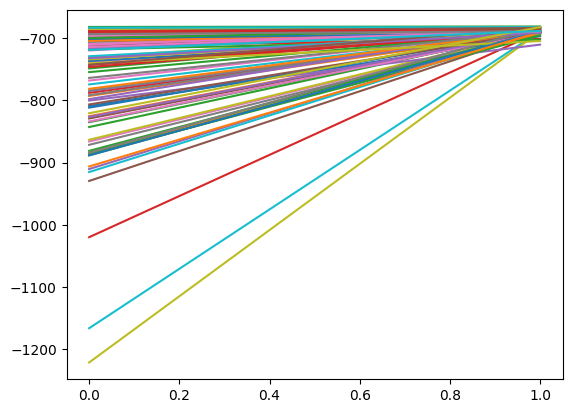

In [54]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(n_attempts):
    ax.plot(list(range(len(ll_list[i]))), ll_list[i])

plt.show()

Plot the Frobenius norm indicating the error between the real value and the estimated value for the matrices $A$, $B$ and $\pi$

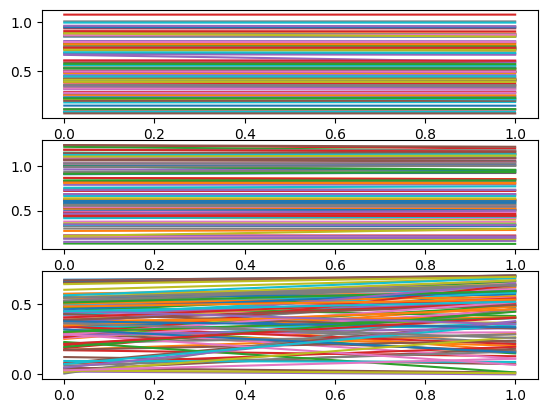

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

for i in range(n_attempts):
    ax1.plot(diff_norms_A[i])
    ax2.plot(diff_norms_B[i])
    ax3.plot(diff_norms_pi[i])
plt.show()


Make a bar chart out of the fraction of correctly predicted states, given the true observations from $t=T_{\text{test}}$ onwards

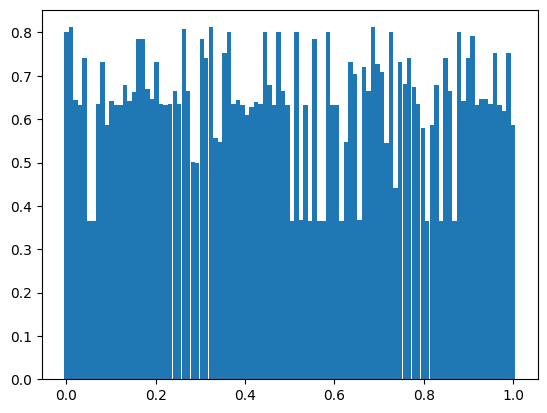

maximum pct correct: 0.812 from attempt 2
minimum pct correct: 0.366 from attempt 6


In [56]:
plt.bar(np.linspace(0, 1, n_attempts), pct_states_matched_viterbi, width=1/(1 + n_attempts))
plt.show()

print('maximum pct correct:', np.max(pct_states_matched_viterbi), 'from attempt', np.argmax(pct_states_matched_viterbi) + 1)
print('minimum pct correct:', np.min(pct_states_matched_viterbi), 'from attempt', np.argmin(pct_states_matched_viterbi) + 1)